In [3]:
import csv
import math
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PAPERS_CSV = "papers_and_authors.csv"
EDGES_CSV = "edges.csv"


papers_df = pd.read_csv(PAPERS_CSV)
edges_df = pd.read_csv(EDGES_CSV)

papers_df.columns = [c.strip() for c in papers_df.columns]
edges_df.columns = [c.strip() for c in edges_df.columns]

paper_authors = {}
paper_year = {}
for _, r in papers_df.iterrows():
    pid = str(r["paper_id"]).strip()
    # Authors field in your sample is a comma-separated list of names
    raw = str(r.get("authors","")).strip()
    # split on comma and strip whitespace
    authors = [a.strip() for a in raw.split(",") if a.strip()]
    paper_authors[pid] = authors
    try:
        paper_year[pid] = int(float(r.get("year", 0)))
    except:
        paper_year[pid] = 0


years = [y for y in paper_year.values() if y > 0]
Ymax = max(years) if years else 2025

print(f"Loaded {len(paper_authors)} papers and {len(edges_df)} paper citations. Ymax={Ymax}")

def build_author_graph_fractional(paper_authors, edges_df):
    AG = nx.DiGraph()
    # add all authors as nodes
    all_authors = set(a for authors in paper_authors.values() for a in authors)
    AG.add_nodes_from(all_authors)

    # accumulate fractional weights for each paper citation
    for _, row in edges_df.iterrows():
        src = str(row["source"]).strip()
        tgt = str(row["target"]).strip()
        if src not in paper_authors or tgt not in paper_authors:
            continue
        src_auth = paper_authors[src]
        tgt_auth = paper_authors[tgt]
        k = len(src_auth)
        m = len(tgt_auth)
        if k == 0 or m == 0:
            continue
        w = 1.0 / (k * m)  # fractional weight per (author_src, author_tgt)
        for a in src_auth:
            for b in tgt_auth:
                if AG.has_edge(a, b):
                    AG[a][b]["weight"] += w
                else:
                    AG.add_edge(a, b, weight=w)
    return AG

AG = build_author_graph_fractional(paper_authors, edges_df)
print(f"Author graph: {AG.number_of_nodes()} authors, {AG.number_of_edges()} edges")

isolates = list(nx.isolates(AG))
if isolates:
    AG.remove_nodes_from(isolates)
    print(f"Removed {len(isolates)} isolated authors. Now {AG.number_of_nodes()} nodes")

author_year = {}
for a in AG.nodes():
    authored = [pid for pid, alist in paper_authors.items() if a in alist]
    years_a = [paper_year.get(pid, 0) for pid in authored if paper_year.get(pid,0) > 0]
    author_year[a] = max(years_a) if years_a else Ymax

Loaded 200 papers and 1377 paper citations. Ymax=2018
Author graph: 621 authors, 9661 edges


In [4]:
def compute_temporal_weighted_hits_author_graph(AG, author_year, Ymax, lambda_decay=0.1,
                                               tol=1e-6, max_iter=1000):
    nodes = list(AG.nodes())
    # temporal weight per author 
    temporal_w = {a: math.exp(-lambda_decay * (Ymax - author_year.get(a, Ymax))) for a in nodes}

    hub = {n: 1.0 for n in nodes}
    auth = {n: 1.0 for n in nodes}
    diffs = []

    for it in range(max_iter):
       
        auth_new = {}
        for n in nodes:
            s = 0.0
            for m in AG.predecessors(n):
                s += hub[m] * AG[m][n].get("weight", 1.0)
            auth_new[n] = temporal_w[n] * s

   
        anorm = math.sqrt(sum(v*v for v in auth_new.values())) or 1.0
        for n in nodes:
            auth_new[n] /= anorm

      
        hub_new = {}
        for n in nodes:
            s = 0.0
            for m in AG.successors(n):
                s += auth_new[m] * AG[n][m].get("weight", 1.0)
            hub_new[n] = temporal_w[n] * s

    
        hnorm = math.sqrt(sum(v*v for v in hub_new.values())) or 1.0
        for n in nodes:
            hub_new[n] /= hnorm

        diff = sum(abs(auth_new[n] - auth[n]) + abs(hub_new[n] - hub[n]) for n in nodes)
        diffs.append(diff)

        auth, hub = auth_new, hub_new

        if diff < tol:
            return hub, auth, diffs, it+1

    return hub, auth, diffs, max_iter

def plot_convergence(diffs, lambda_decay):
    plt.figure(figsize=(5,3))
    plt.plot(diffs, marker=".", linewidth=1)
    plt.xlabel("Iteration")
    plt.ylabel("Residual")
    plt.title(f"Temporal HITS convergence (λ={lambda_decay})")
    plt.tight_layout()
    plt.show()


=== λ = 0.001 ===
Converged in 11 iterations. Top authors by authority:
 1. Yoshua Bengio                   (2017)  → 0.5024
 2. Alex Graves                     (2016)  → 0.4178
 3. Sepp Hochreiter                 (2001)  → 0.3408
 4. Holger Schwenk                  (2014)  → 0.2224
 5. Kyunghyun Cho                   (2016)  → 0.2130
 6. J. Schmidhuber                  (2015)  → 0.2073
 7. Phil Blunsom                    (2016)  → 0.1920
 8. I. Sutskever                    (2015)  → 0.1904
 9. O. Vinyals                      (2016)  → 0.1581
10. Dzmitry Bahdanau                (2016)  → 0.1479

Top authors by hub:
 1. Yoshua Bengio                   (2017)  → 0.4932
 2. Kyunghyun Cho                   (2016)  → 0.4559
 3. Dzmitry Bahdanau                (2016)  → 0.3787
 4. Lukasz Kaiser                   (2017)  → 0.2572
 5. I. Sutskever                    (2015)  → 0.2459
 6. Alex Graves                     (2016)  → 0.2233
 7. Quoc V. Le                      (2017)  → 0.2153
 8. O

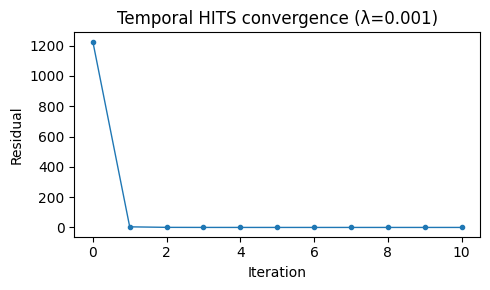


=== λ = 0.01 ===
Converged in 11 iterations. Top authors by authority:
 1. Yoshua Bengio                   (2017)  → 0.5163
 2. Alex Graves                     (2016)  → 0.4251
 3. Sepp Hochreiter                 (2001)  → 0.3024
 4. Holger Schwenk                  (2014)  → 0.2226
 5. Kyunghyun Cho                   (2016)  → 0.2176
 6. J. Schmidhuber                  (2015)  → 0.2090
 7. Phil Blunsom                    (2016)  → 0.1958
 8. I. Sutskever                    (2015)  → 0.1929
 9. O. Vinyals                      (2016)  → 0.1617
10. Dzmitry Bahdanau                (2016)  → 0.1510

Top authors by hub:
 1. Yoshua Bengio                   (2017)  → 0.4956
 2. Kyunghyun Cho                   (2016)  → 0.4546
 3. Dzmitry Bahdanau                (2016)  → 0.3778
 4. Lukasz Kaiser                   (2017)  → 0.2604
 5. I. Sutskever                    (2015)  → 0.2433
 6. Alex Graves                     (2016)  → 0.2176
 7. Quoc V. Le                      (2017)  → 0.2170
 8. O.

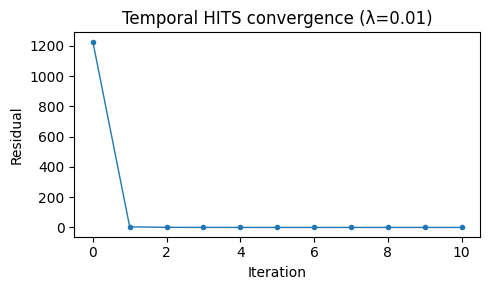


=== λ = 0.1 ===
Converged in 11 iterations. Top authors by authority:
 1. Yoshua Bengio                   (2017)  → 0.5941
 2. Alex Graves                     (2016)  → 0.4425
 3. Kyunghyun Cho                   (2016)  → 0.2332
 4. Phil Blunsom                    (2016)  → 0.2067
 5. J. Schmidhuber                  (2015)  → 0.1999
 6. Holger Schwenk                  (2014)  → 0.1948
 7. I. Sutskever                    (2015)  → 0.1898
 8. O. Vinyals                      (2016)  → 0.1748
 9. Dzmitry Bahdanau                (2016)  → 0.1613
10. Nal Kalchbrenner                (2016)  → 0.1581

Top authors by hub:
 1. Yoshua Bengio                   (2017)  → 0.5193
 2. Kyunghyun Cho                   (2016)  → 0.4374
 3. Dzmitry Bahdanau                (2016)  → 0.3630
 4. Lukasz Kaiser                   (2017)  → 0.2853
 5. Quoc V. Le                      (2017)  → 0.2334
 6. I. Sutskever                    (2015)  → 0.2162
 7. O. Vinyals                      (2016)  → 0.2032
 8. Ale

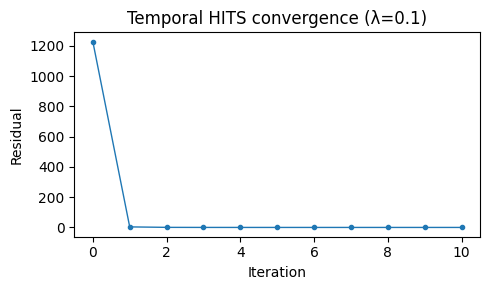


=== λ = 0.5 ===
Converged in 10 iterations. Top authors by authority:
 1. Yoshua Bengio                   (2017)  → 0.7551
 2. Alex Graves                     (2016)  → 0.3627
 3. Quoc V. Le                      (2017)  → 0.2099
 4. Kyunghyun Cho                   (2016)  → 0.2047
 5. Phil Blunsom                    (2016)  → 0.1732
 6. O. Vinyals                      (2016)  → 0.1572
 7. Dzmitry Bahdanau                (2016)  → 0.1403
 8. Nal Kalchbrenner                (2016)  → 0.1341
 9. J. Schmidhuber                  (2015)  → 0.1159
10. I. Sutskever                    (2015)  → 0.1129

Top authors by hub:
 1. Yoshua Bengio                   (2017)  → 0.6082
 2. Lukasz Kaiser                   (2017)  → 0.3458
 3. Kyunghyun Cho                   (2016)  → 0.3406
 4. Quoc V. Le                      (2017)  → 0.2917
 5. Dzmitry Bahdanau                (2016)  → 0.2767
 6. O. Vinyals                      (2016)  → 0.1660
 7. Alex Graves                     (2016)  → 0.1546
 8. Min

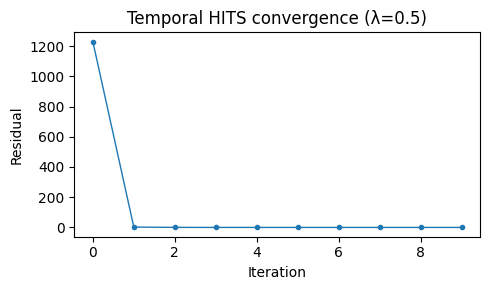


=== λ = 1.0 ===
Converged in 9 iterations. Top authors by authority:
 1. Yoshua Bengio                   (2017)  → 0.8519
 2. Quoc V. Le                      (2017)  → 0.2490
 3. Alex Graves                     (2016)  → 0.2369
 4. Kyunghyun Cho                   (2016)  → 0.1448
 5. Phil Blunsom                    (2016)  → 0.1168
 6. Geoffrey E. Hinton              (2017)  → 0.1146
 7. Christopher D. Manning          (2017)  → 0.1141
 8. O. Vinyals                      (2016)  → 0.1138
 9. Dzmitry Bahdanau                (2016)  → 0.0981
10. Nal Kalchbrenner                (2016)  → 0.0918

Top authors by hub:
 1. Yoshua Bengio                   (2017)  → 0.6682
 2. Lukasz Kaiser                   (2017)  → 0.3835
 3. Quoc V. Le                      (2017)  → 0.3318
 4. Kyunghyun Cho                   (2016)  → 0.2243
 5. Dzmitry Bahdanau                (2016)  → 0.1793
 6. Minh-Thang Luong                (2017)  → 0.1450
 7. Noam M. Shazeer                 (2017)  → 0.1178
 8. Alex

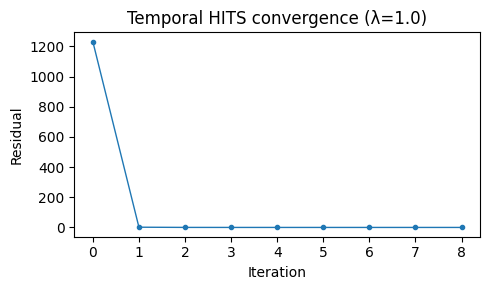


Done.


In [5]:
author_names_map = {a: a for a in AG.nodes()}  # identity mapping (names are nodes)

lambda_values = [0.001, 0.01, 0.1, 0.5, 1.0]

for lam in lambda_values:
    print("\n=== λ =", lam, "===")
    hub_scores, auth_scores, diffs, iters = compute_temporal_weighted_hits_author_graph(AG, author_year, Ymax, lambda_decay=lam)
    print(f"Converged in {iters} iterations. Top authors by authority:")

    top_auth = sorted(auth_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    for rank, (a, sc) in enumerate(top_auth, 1):
        print(f"{rank:2d}. {author_names_map.get(a,a):30s}  ({author_year.get(a,'NA')})  → {sc:.4f}")

    print("\nTop authors by hub:")
    top_hub = sorted(hub_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    for rank, (a, sc) in enumerate(top_hub, 1):
        print(f"{rank:2d}. {author_names_map.get(a,a):30s}  ({author_year.get(a,'NA')})  → {sc:.4f}")

    plot_convergence(diffs, lam)
    
print("\nDone.")